# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.166896,False,-1.221893
1,-0.437662,False,-0.601438
2,-1.436948,False,-1.757200
3,-0.493307,False,-0.776904
4,-0.510537,False,-2.276785
...,...,...,...
995,-0.424548,True,3.172706
996,-2.189782,False,-5.593129
997,-1.442641,False,-1.686951
998,-0.465033,False,-1.085073


<AxesSubplot: xlabel='v0'>

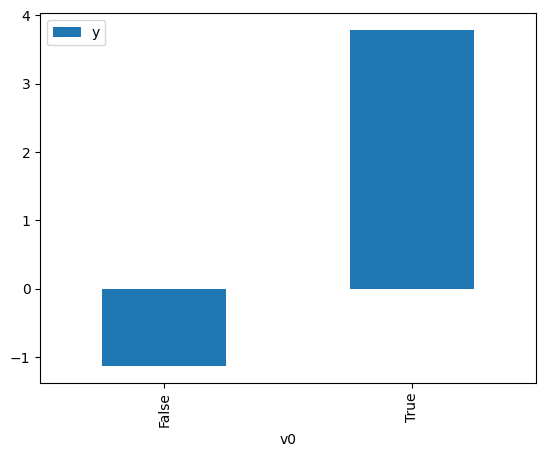

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

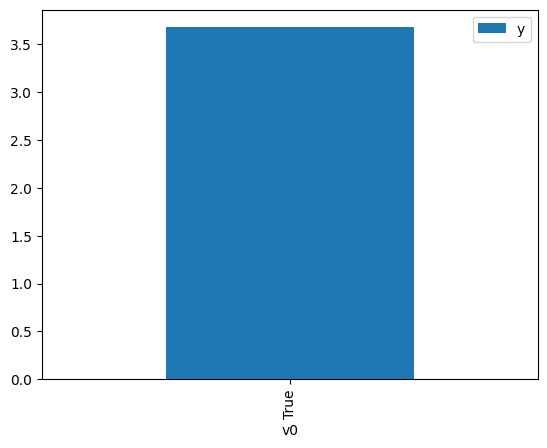

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.727373,False,-2.044442,0.704567,1.419311
1,-0.100094,False,-0.768654,0.524367,1.907061
2,-0.229798,False,-1.606128,0.563921,1.773297
3,-2.188735,False,-4.935452,0.935034,1.069480
4,0.238044,False,-0.068065,0.421069,2.374908
...,...,...,...,...,...
995,-1.236437,False,-2.731985,0.816876,1.224175
996,-0.442759,False,0.155065,0.626925,1.595087
997,-1.304271,False,-2.091874,0.829030,1.206229
998,-0.906838,False,-2.258631,0.748362,1.336251


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.157632,True,4.997642,0.554649,1.802941
1,-0.676461,True,3.399576,0.308633,3.240093
2,-0.173843,True,4.789088,0.453073,2.207151
3,0.114869,True,4.764298,0.541622,1.846307
4,-3.116843,True,-3.316126,0.021703,46.076259
...,...,...,...,...,...
995,0.544168,True,7.022507,0.667065,1.499104
996,-0.202201,True,4.535001,0.444444,2.250002
997,0.076180,True,4.161181,0.529785,1.887557
998,0.656732,True,7.091007,0.697074,1.434569


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              7616.
Date:                Mon, 17 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:14:51   Log-Likelihood:                         -1402.6
No. Observations:                1000   AIC:                                      2809.
Df Residuals:                     998   BIC:                                      2819.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0064      0.026     75.812      0.000       1.954       2.058
x2             4.9750      0.051     96.643      0.000       4.874       5.076
==============================================================================
Omnibus:                        3.911   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.767
Skew:                           0.135   Prob(JB):                        0.152
Kurtosis:                       3.134   Cond. No.                         1.95
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""